<a href="https://colab.research.google.com/github/PaulToronto/DataCamp-Track---Machine-Learning-Scientist-in-Python/blob/main/8_1_Extreme_Gradient_Boosting_with_XGBoost_Classification_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8-1 Extreme Gradient Boosting with XGBoost - Classification with XGBoost

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, auc
from itertools import product

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import load_breast_cancer

## Data

In [2]:
base_url = 'https://drive.google.com/uc?id='

### Churn Data

In [3]:
id = '12kXMuIe5nuV71YOS1roQqQ-8nKENhtZG'
churn_data = pd.read_csv(base_url + id)
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   avg_dist                     50000 non-null  float64
 1   avg_rating_by_driver         49799 non-null  float64
 2   avg_rating_of_driver         41878 non-null  float64
 3   avg_inc_price                50000 non-null  float64
 4   inc_pct                      50000 non-null  float64
 5   weekday_pct                  50000 non-null  float64
 6   fancy_car_user               50000 non-null  bool   
 7   city_Carthag                 50000 non-null  int64  
 8   city_Harko                   50000 non-null  int64  
 9   phone_iPhone                 50000 non-null  int64  
 10  first_month_cat_more_1_trip  50000 non-null  int64  
 11  first_month_cat_no_trips     50000 non-null  int64  
 12  month_5_still_here           50000 non-null  int64  
dtypes: bool(1), floa

## Welcome to the course

### Supervised learning

- Relies on labeled data
- Have osme understanding of past behaviour
- Two types of supervised learning problems
  - **Classification problems**
    - Outcome can be **binary** or **multi-class**
  - **Regression problems**

### Evaluation metrics

- Area under the ROC curve (AUC), is the most versatile and common evaluation metric used to judge the quality of a binary classification  model
- It is simply the **probability** that a **randomly chosen positive** data point will have a **higher score** (or rank) than a **randomly chosen negative** data point for your learning problem
- A higher AUC means a more sensitive better performing model

#### Explanation of that definition

Imagine your model gives a **score** to each data point (not just 0/1, but a probability or real value). Let's say:

- Positive example gets score **0.9**
- Negative example gets scoore **0.2**

That's **good** but sometimes the model might predict a higher probability for the negative data point, which is **bad**.

**AUC asks: How often does your model get the ranking right?** It simulates this:

- Pick a random positive example
- Pick a random negative example
- Ask: **Did the model score the positive higher than the negative?**
- Repeat this many times. The **proportion of times** the model ranks the postive higher is the AUC.
- Tha AUC is also the **area under the ROC curve**, which plots:
  - True Positive Rate vs False Positive Rate
- Note that `roc_auc_score` in sklearn does not use random sampling to obtain the score, it does it exhaustively.

- For multi-class classification problems it is common to use **accuracy score** and to look at the overall **confusion matrix** to evaluate the quality of a model

- Accuracy:

$$
\frac{tp + tn}{tp + tn + fp + fn}
$$

### AUC Experiments

In [4]:
y_true = [1, 1, 0, 0, 1, 0]
y_scores = [0.9, 0.7, 0.6, 0.4, 0.5, 0.5]

positives = [s for y, s in zip(y_true, y_scores) if y == 1]
negatives = [s for y, s in zip(y_true, y_scores) if y == 0]

positives, negatives

([0.9, 0.7, 0.5], [0.6, 0.4, 0.5])

In [5]:
pairs = list(product(positives, negatives))
pairs

[(0.9, 0.6),
 (0.9, 0.4),
 (0.9, 0.5),
 (0.7, 0.6),
 (0.7, 0.4),
 (0.7, 0.5),
 (0.5, 0.6),
 (0.5, 0.4),
 (0.5, 0.5)]

In [6]:
# compute AUC manually
score = 0
for pos, neg in pairs:
    if pos > neg:
        score += 1
    elif pos == neg:
        score += 0.5
    else:
        score += 0 # redundant, included for clarity

auc_manual = score / len(pairs)

auc_manual, roc_auc_score(y_true, y_scores).item()

(0.8333333333333334, 0.8333333333333333)

In [7]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.33333333, 0.66666667,
        1.        ]),
 array([0.        , 0.33333333, 0.66666667, 0.66666667, 1.        ,
        1.        ]),
 array([inf, 0.9, 0.7, 0.6, 0.5, 0.4]))

In [8]:
roc_auc = auc(fpr, tpr)
roc_auc

np.float64(0.8333333333333333)

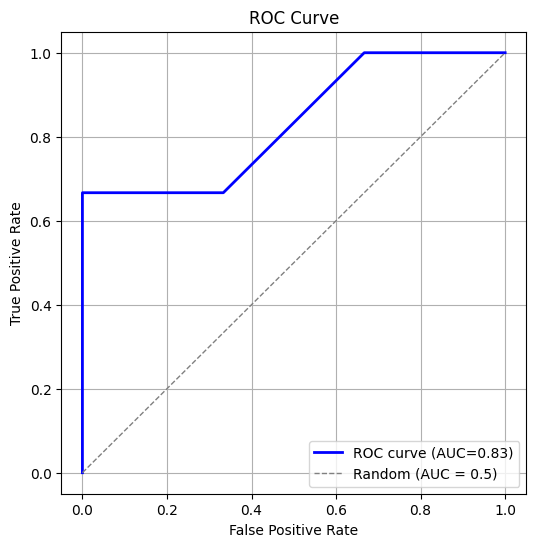

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Supervised Learning Review

- Supervised learning with `sklearn`
  - Logistic regression
  - Decision trees

### Other supervised learning considerations

- Features can be either numeric or categorical
- It is usually the case that numeric features should be scaled (z-scored)
  - Essential to ensure properly trained support vector machine models
- Categorical fatures should be encoded (one-hot)

### Other kinds of supervised learning problems

- **Ranking problems**
  - Predicing an ordering on a set of choices (like google search hits)
- **Recommendation**
  - Recommending at item to a user
    - Based on consumpition history and profile
    - Example: Netflix

## Introducing XGBoost

### What is XGBoost?

- Optimized gradient-boosting machine learning library
- Originally written in C++
- Became well known after it was used to win a Kaggle Competition: https://www.kaggle.com/c/higgs-boson
- Has APIs in several languages
  - Python, R, Scala, Julia, Java

### What makes XGBoost so popular?

- Speed and performance
- Core algorithm is parallelizable
- Consistently outperforms single-algorithm methods
- State-of-the-art performance in many ML tasks

### Using XGBoost: a quick example

XGBoost has a scikit-learn compatible API.

```python
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import tain_test_splot

class_data = pd.read_csv('classification_data.csv')

X, y = class_data.iloc[:, :-1], class_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=123
)

xg_cl = xgb.XGBClassifier(
    objective='binary:logisitic',
    n_estimators=10,
    seed=123
)

xg_cl.fit(X_train, y_train)

preds = xg_cl.predict(X_test)
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]

print('accuracy: %f' % (accuracy))
```

### XGBoost: Fit/Predict

In [10]:
# Create arrays for the features and the target: X, y
X, y = churn_data.iloc[:,:-1], churn_data.iloc[:,-1]

In [11]:
y.value_counts()

,count
month_5_still_here,
0,27506
1,22494


In [12]:
# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Fit the classifier to the training set
xg_cl.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.759400


## What is a decision tree? (review)

### Decision trees as base learners

- **Base learner**: Individual learning algorithm in an ensemble algorithm
- Composed for a series of binary questions
- Predictions happen at the **leaves** of the tree

### Decision trees and CART

- Constructed iteratively (one decision at a time)
  - Until as stopping criterion is met
- Each **leaf** of the decision tree will have a single category in the majority (or a majority of one category)
- Individual decsion trees tend to overfit (high variance / low bias)
  - Usually generalize to new data poorly



### CART: Classification and Regression Trees

- XGBoost uses a slightly different kind of a decision tree, caxlled a **Classification and Regression Tree (CART)**
- CART trees contain a real-valued score in each leaf, regardless of whether they are used for classification or regression
- The real-valued scores can then be thresholded to convert into categories for classification problems if necessary

### Decision Trees

In [13]:
X, y = load_breast_cancer(return_X_y=True, as_frame=False)
X.shape, y.shape

((569, 30), (569,))

In [14]:
# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [15]:
# Instantiate the classifier: dt_clf_4
dt_clf_4 = DecisionTreeClassifier(max_depth=4)
dt_clf_4

DecisionTreeClassifier(max_depth=4)

In [16]:
# Fit the classifier to the training set
dt_clf_4.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [17]:
# Predict the labels of the test set: y_pred_4
y_pred_4 = dt_clf_4.predict(X_test)
y_pred_4

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0])

In [18]:
# Compute the accuracy of the predictions: accuracy
accuracy = float(np.sum(y_pred_4==y_test))/y_test.shape[0]
print("accuracy:", accuracy)

accuracy: 0.9649122807017544


## What is Boosting?

### Boosting overview

- Not really a specific ML algorithm, but a concpet that can be applied to a set of ML models
- It's really a **meta-algorithm**
- It's an ensemble meta-algorithm
- Used to reduce any single learner's variance and convert many weak learners into an arbitrarily strong learner

### Weak learners and strong learners

- **Weak learner**: ML algorithm that is slightly better than chance
  - Example: Decision tree whose predictions are slightly better than 50%
- **Boosting** converts a collection of weak learners into a strong learner
- **Strong learner**: Any algorithm that can be tuned to achieve good performance

### How boosting is accomplished

- Iteratively learning a set of weak models on subsets of the data
- Weighting each weak prediction according to each weak learner's performance
- Combine the weighted predictions to obtain a single weighted prediction

### Boosting Example

<img src='https://drive.google.com/uc?export=view&id=1Ml98n6EbXDWPQ7yg2apF-Nr-rIiMtHAa'>

- Here you can see, that "whatever we were trying to predict", the little boy has a higher predicted score summed across both trees than the old man

### XGBoost can use one two APIs

1. Scikit-learn API
2. Naving API

In [19]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100, n_features=4, random_state=42)
np.unique(y, return_counts=True)

(array([0, 1]), array([50, 50]))

In [20]:
# Scikit-learn API

model = xgb.XGBClassifier(
    max_depth=3,
    n_estimators=10,
    learning_rate=0.1,
    eval_metric='logloss')

model.fit(X, y)
preds = model.predict_proba(X)[:, 1]
preds

array([0.8000265 , 0.19835848, 0.8000265 , 0.19835848, 0.19835848,
       0.673887  , 0.19835848, 0.8000265 , 0.19835848, 0.19835848,
       0.8000265 , 0.19835848, 0.7863236 , 0.19835848, 0.19835848,
       0.8000265 , 0.8000265 , 0.8000265 , 0.4252176 , 0.8000265 ,
       0.673887  , 0.48964947, 0.19835848, 0.19835848, 0.19835848,
       0.7863236 , 0.8000265 , 0.24294452, 0.19835848, 0.19835848,
       0.8000265 , 0.8000265 , 0.8000265 , 0.4252176 , 0.8000265 ,
       0.6552652 , 0.8000265 , 0.19835848, 0.8000265 , 0.8000265 ,
       0.8000265 , 0.19835848, 0.19835848, 0.19835848, 0.19835848,
       0.8000265 , 0.8000265 , 0.40710846, 0.7863236 , 0.19835848,
       0.8000265 , 0.19835848, 0.19835848, 0.48964947, 0.4252176 ,
       0.8000265 , 0.8000265 , 0.19835848, 0.19835848, 0.7075395 ,
       0.19835848, 0.8000265 , 0.8000265 , 0.8000265 , 0.19835848,
       0.19835848, 0.19835848, 0.19835848, 0.19835848, 0.8000265 ,
       0.19835848, 0.8000265 , 0.19835848, 0.7863236 , 0.80002

In [21]:
# Native API
dtrain = xgb.DMatrix(X, label=y)

# define parameters explicitly
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'eta': 0.1,
    'eval_metric': 'logloss'
}

booster = xgb.train(params, dtrain, num_boost_round=10)

pred_2 = booster.predict(dtrain)
pred_2

array([0.8000265 , 0.19835848, 0.8000265 , 0.19835848, 0.19835848,
       0.673887  , 0.19835848, 0.8000265 , 0.19835848, 0.19835848,
       0.8000265 , 0.19835848, 0.7863236 , 0.19835848, 0.19835848,
       0.8000265 , 0.8000265 , 0.8000265 , 0.4252176 , 0.8000265 ,
       0.673887  , 0.48964947, 0.19835848, 0.19835848, 0.19835848,
       0.7863236 , 0.8000265 , 0.24294452, 0.19835848, 0.19835848,
       0.8000265 , 0.8000265 , 0.8000265 , 0.4252176 , 0.8000265 ,
       0.6552652 , 0.8000265 , 0.19835848, 0.8000265 , 0.8000265 ,
       0.8000265 , 0.19835848, 0.19835848, 0.19835848, 0.19835848,
       0.8000265 , 0.8000265 , 0.40710846, 0.7863236 , 0.19835848,
       0.8000265 , 0.19835848, 0.19835848, 0.48964947, 0.4252176 ,
       0.8000265 , 0.8000265 , 0.19835848, 0.19835848, 0.7075395 ,
       0.19835848, 0.8000265 , 0.8000265 , 0.8000265 , 0.19835848,
       0.19835848, 0.19835848, 0.19835848, 0.19835848, 0.8000265 ,
       0.19835848, 0.8000265 , 0.19835848, 0.7863236 , 0.80002

In [22]:
(preds - pred_2).sum()

np.float32(0.0)

In [23]:
# you can get the underlying booster from a trained XGBClassifier
test_booster = model.get_booster()
pred_3 = test_booster.predict(dtrain)
pred_3

array([0.8000265 , 0.19835848, 0.8000265 , 0.19835848, 0.19835848,
       0.673887  , 0.19835848, 0.8000265 , 0.19835848, 0.19835848,
       0.8000265 , 0.19835848, 0.7863236 , 0.19835848, 0.19835848,
       0.8000265 , 0.8000265 , 0.8000265 , 0.4252176 , 0.8000265 ,
       0.673887  , 0.48964947, 0.19835848, 0.19835848, 0.19835848,
       0.7863236 , 0.8000265 , 0.24294452, 0.19835848, 0.19835848,
       0.8000265 , 0.8000265 , 0.8000265 , 0.4252176 , 0.8000265 ,
       0.6552652 , 0.8000265 , 0.19835848, 0.8000265 , 0.8000265 ,
       0.8000265 , 0.19835848, 0.19835848, 0.19835848, 0.19835848,
       0.8000265 , 0.8000265 , 0.40710846, 0.7863236 , 0.19835848,
       0.8000265 , 0.19835848, 0.19835848, 0.48964947, 0.4252176 ,
       0.8000265 , 0.8000265 , 0.19835848, 0.19835848, 0.7075395 ,
       0.19835848, 0.8000265 , 0.8000265 , 0.8000265 , 0.19835848,
       0.19835848, 0.19835848, 0.19835848, 0.19835848, 0.8000265 ,
       0.19835848, 0.8000265 , 0.19835848, 0.7863236 , 0.80002

In [24]:
(preds - pred_3).sum()

np.float32(0.0)

### Model evaluation through cross-validation

- Since we are working with XGBoost's learning API for model evaluation (not sklearn), we need an example
- XGBoost has cross-validation abilities baked in
- Cross-validation: Robust method for estimating the performance of a model on unseen data
  - Generates many non-overlapping train/test splits on training data
  - Reports the average test set performance across all data splits

```python
import xgboost as xgb
import pandas as pd

churn_data = pd.read_csv('classification_data.csv')
churn_dmatrix = xgb.DMatrix(
    data=churn_data.iloc[:, :-1],
    label=churn_data.month_5_still_here
)
params = {'objective':'binary:logistic', 'max_depth':4}

cv_results = xgb.cv(
    dtrain=churn_dmatrix,
    params=params,
    nfold=4,
    num_boost_round=10,
    metrics='error',
    as_pandas=True
)
print('Accuracy: %f' % ((1 - cv_results['test-error-mean']).iloc[-1]))

```



In [25]:
# try it with X, y
dtrain = xgb.DMatrix(X, label=y)

params = {'objective':'binary:logistic', 'max_depth':4}

cv_results = xgb.cv(
    dtrain=dtrain,
    params=params,
    nfold=4,
    num_boost_round=10,
    metrics='error',
    as_pandas=True
)

cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.036667,0.005774,0.08,0.028284
1,0.033333,0.006667,0.07,0.033166
2,0.033333,0.006667,0.07,0.033166
3,0.033333,0.006667,0.07,0.033166
4,0.033333,0.006667,0.07,0.033166
5,0.033333,0.006667,0.07,0.033166
6,0.023333,0.011055,0.06,0.034641
7,0.020000,0.014907,0.06,0.034641
8,0.013333,0.009428,0.04,0.000000
9,0.020000,0.014907,0.06,0.034641


In [26]:
print('Accuracy: %f' % ((1 - cv_results['test-error-mean']).iloc[-1]))

Accuracy: 0.940000


### Measuring accuracy

In [27]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   avg_dist                     50000 non-null  float64
 1   avg_rating_by_driver         49799 non-null  float64
 2   avg_rating_of_driver         41878 non-null  float64
 3   avg_inc_price                50000 non-null  float64
 4   inc_pct                      50000 non-null  float64
 5   weekday_pct                  50000 non-null  float64
 6   fancy_car_user               50000 non-null  bool   
 7   city_Carthag                 50000 non-null  int64  
 8   city_Harko                   50000 non-null  int64  
 9   phone_iPhone                 50000 non-null  int64  
 10  first_month_cat_more_1_trip  50000 non-null  int64  
 11  first_month_cat_no_trips     50000 non-null  int64  
 12  month_5_still_here           50000 non-null  int64  
dtypes: bool(1), floa